In [2]:
%pylab inline
import tensorflow as tf
import sys
sys.path.insert(0, '../python')

Populating the interactive namespace from numpy and matplotlib


/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/local/home/fnammour/m

# Step I: Reading data

In [3]:
from DeepDeconv.utils.batch_utils import dynamic_batches

In [4]:
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/"

#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-*-multihdu.fits')
gal_files.sort()

SNR = [20,100]#Range of SNR simulated
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
deconv_mode = 'TIKHONOV'

In [5]:
gen = dynamic_batches(gal_files[2:] , batch_size=32, noise_std=None, SNR=SNR, 
                noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                deconv_mode=deconv_mode)

In [6]:
a = next(gen)

In [7]:
a[0].shape, a[1].shape, a[2].shape

((32, 96, 96, 1), (32, 96, 96, 1), (32,))

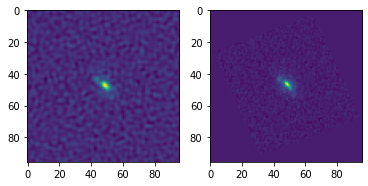

In [8]:
subplot(121)
imshow(a[0][3,:,:,0])
subplot(122)
imshow(a[1][3,:,:,0])

## Step II: Define a network

In [9]:
# Redefine the DenseBlock function here instead of using the one in 
# ShapeDeconv/python/DeepDeconv/deepnetFCS/DeconvNet_custom.py
# to avoid conflicts between imported libraries

def DenseBlock(n_layers, n_kernels, input_layer, activation_function='swish',
                                            axis_concat=3, concat_input=True,dilation_rate=1):
    #concat_input: implies that we have a skip concatenation between input and output of block
    connect_input = input_layer
    for n in range(n_layers):
        bn = tf.keras.layers.BatchNormalization()(connect_input)
        act = tf.keras.layers.Activation(activation_function)(bn)
        conv = tf.keras.layers.SeparableConv2D(n_kernels, 3, padding='same', use_bias=False,
                                        kernel_initializer='he_uniform')(act)
        if n == 0:
            concat = conv
        else:
            concat = tf.keras.layers.Concatenate(axis = axis_concat)([concat, conv])
        connect_input = concat
    if concat_input:
        return tf.keras.layers.Concatenate(axis = axis_concat)([input_layer, concat])
    return concat

# Define the modified U-net
img_rows = img_cols = 96
nb_scales = 4
growth_rate = 12
nb_layers_per_block = [4,5,6,7]
activation_function= 'relu'
gamma=1


#NETWORK CONSTRUCTION STARTS HERE

inputs = tf.keras.Input(shape=[img_rows, img_cols, 1])

#INPUT CONV
net = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_uniform')(inputs)

#CONTRACTING PATH
skip_connect = []

for scale in range(nb_scales-1):
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=True)
    skip_connect.append(block)
    batch_norm = tf.keras.layers.BatchNormalization()(block)
    activation = tf.keras.layers.Activation(activation_function)(batch_norm)
    conv_transi = tf.keras.layers.Conv2D(32+np.sum(nb_layers_per_block[:scale+1])*growth_rate, 1, 
                         padding='same', use_bias=False, kernel_initializer='he_uniform')(activation)
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv_transi)

#BOTTLENECK
block = DenseBlock(n_layers=nb_layers_per_block[-1],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=False)


#EXPANSIVE PATH
for scale in range(nb_scales-2, -1, -1):   
    up = tf.keras.layers.Conv2D(nb_layers_per_block[scale+1]*growth_rate, 2, activation = activation_function,
             padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(block))
    net = tf.keras.layers.Concatenate(axis = 3)([up, skip_connect[scale]])
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=False)

#FUSION AND SKIP CONNECT
batch_norm = tf.keras.layers.BatchNormalization()(block)
activation = tf.keras.layers.Activation(activation_function)(batch_norm)
outputs = tf.keras.layers.Conv2D(1, 1, activation = 'linear')(activation)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = 'mse', metrics=['accuracy'])

## Print Model Summary

In [11]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Step III: Training

In [ ]:
# Train the model
history = model.fit_generator(gen, 
                              steps_per_epoch=100,
                              epochs=20)

In [ ]:
# have a look at history
history
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Step IV: Applying the model

In [ ]:
# The model can be applied like so:
res = model(a[0].astype('float32'))
# This should return the solution of the deconvolution prblm
res_np = tf.keras.backend.eval(res).squeeze(axis=-1) #convert solution to numpy array and remove last dimension

In [ ]:
# Show a deconvolved image
figure()
imshow(a[0][0].squeeze(axis=-1))
title('Dirty')
figure()
imshow(res_np[0])
title('Deconvolved')